# Boltzmann
In this notebook, the problem is simplified to 2 neurons. The clamped dataset consists of pairs in which the first component of each datapoint equals the second component of each datapoint.

In [1]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Calculate clamped statistics
In the next section, functions are defined for calculating clamped statistics $\langle x_i \rangle$ and $\langle x_i x_j \rangle$ which are defined as follows:
\begin{align}
\langle x_i \rangle_c &:= \frac{1}{P} \sum\limits_{\mu} x_i^{\mu}\\
\langle x_i x_j\rangle_c &:= \frac{1}{P} \sum\limits_{\mu} x_i^{\mu} x_j^{\mu}
\end{align}

In [2]:
def calculate_clamped_statistics(X):
    """
    Calculate <x_i>_c and <x_i x_j>_c given X.
    """
    num_datapoints = X.shape[0]
    return np.sum(X, axis=0) / num_datapoints, np.dot(X.T, X) / num_datapoints

### Testing clamped statistics calculation

Now we will test the calculate statistics method with an easy example:
\begin{align}
X := 
\begin{pmatrix} 
  1 & -1\\
  -1 & -1\\
  1 & 1\\
  1 & 1
\end{pmatrix}
\end{align}

Each row represents a datapoint consisting of two elements. So the clamped statistics should equal the following:

\begin{align}
\langle X_1 \rangle_c &= \frac{1}{4} \cdot (1 + -1 + 1 + 1) = \frac{2}{4} = \frac{1}{2}\\
\langle X_2 \rangle_c &= \frac{1}{4} \cdot (-1 + -1 + 1 + 1) = 0
\end{align}

We also can compute $\langle X_i X_j \rangle_c$:
\begin{align}
\langle X_1 X_1 \rangle_c &= \frac{1}{4} \cdot (1 \cdot 1 + -1 \cdot -1 + 1 \cdot 1 + 1 \cdot 1) = \frac{1}{4} \cdot 4 = 1\\
\langle X_1 X_2 \rangle_c &= \frac{1}{4} \cdot (1 \cdot -1 + -1 \cdot -1 + 1 \cdot 1 + 1 \cdot 1) = \frac{2}{4} = \frac{1}{2}\\
\langle X_2 X_1 \rangle_c &= \frac{1}{4} \cdot (-1 \cdot 1 + -1 \cdot -1 + 1 \cdot 1 + 1 \cdot 1) = \frac{2}{4} = \frac{1}{2}\\
\langle X_2 X_2 \rangle_c &= \frac{1}{4} \cdot (-1 \cdot -1 + -1 \cdot -1 + 1 \cdot 1 + 1 \cdot 1) = \frac{1}{4} \cdot 4 = 1\\
\end{align}

In [3]:
# Testing calculate clamped statistics
X = np.matrix([
    [1, -1],
    [-1, -1],
    [1, 1],
    [1, 1]
])
stats = calculate_clamped_statistics(X)
print("<x_i>_c should equal:\t\t[0.50, 0.00]\n<x_i>_c computed value:\t\t[%.2f, %.2f]" % (stats[0].item(0), stats[0].item(1)))
print("<x_i x_j>_c should equal:\t[[1.00, 0.50], [0.50, 1.00]]\n<x_i x_j>_c computed value:\t[[%.2f, %.2f], [%.2f, %.2f]]" % (stats[1].item((0, 0)), stats[1].item((0, 1)), stats[1].item((1, 0)), stats[1].item((1, 1))))

<x_i>_c should equal:		[0.50, 0.00]
<x_i>_c computed value:		[0.50, 0.00]
<x_i x_j>_c should equal:	[[1.00, 0.50], [0.50, 1.00]]
<x_i x_j>_c computed value:	[[1.00, 0.50], [0.50, 1.00]]


## Calculate energy
Energy is defined as $E(s) := -\frac{1}{2} \sum\limits_{ij} w_{ij} s_i s_j - \sum\limits_{i} \theta_i s_i$. Where $s$ is a single state. Let $S$ represent a matrix where each row is a state. Then: $E_n(S) = -\frac{1}{2} \sum\limits_{ij} w_{ij} S_{ni} s_{nj} - \sum\limits_{i} \theta_i s_{ni}$. This is a generalization of the first definition. Note furthermore that:
\begin{align}
E_n(S) &= -\frac{1}{2} \sum\limits_i \sum\limits_j w_{ij} (S^{T})_{jn} S_{ni} - \sum\limits_i \theta_{i} S_{ni}\\
E_n(S) &= -\frac{1}{2} \sum\limits_i S_{ni} \sum\limits_j w_{ij} (S^{T})_{jn} - \sum\limits_i \theta_{i} S_{ni}
\end{align}

Now define $Q_{in} := \sum\limits_j w_{ij} (S^{T})_{jn} = (w \cdot S^{T})_{in}$. Then:

\begin{align}
E_n(S) &= -\frac{1}{2} \sum\limits_i S_{ni} Q_{in} - \sum\limits_i \theta_{i} S_{ni}\\
E_n(S) &= -\frac{1}{2} (S \cdot Q)_{nn} - \sum\limits_i \theta_{i} (S^{T})_{in}\\
E_n(S) &= -\frac{1}{2} (S \cdot Q)_{nn} - \theta \cdot S^{T}\\
E_n(S) &= -\frac{1}{2} (S \cdot (w \cdot S^{T}))_{nn} - \theta \cdot S^{T}\\
\end{align}

This last definition is used in the calculation for the energy. With $n=1$ it simplifies to the one dimensional case.

In [4]:
def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    # Also allow samples consisting of one sample (an array, so f.ndim == 1)
    # Therefore, only take the diagonal in the two dimensional case
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

### Testing energy calculation

We will test the energy calculation for a simple case with two samples. Define:

\begin{align}
w := \begin{pmatrix} 
  1 & 0\\
  -1 & 1
\end{pmatrix}
\theta := \begin{pmatrix} 
  -1\\
  -1
\end{pmatrix}
S := \begin{pmatrix}
1 & -1\\
0 & 1
\end{pmatrix}
\end{align}

Then:
\begin{align}
E_1(S) &= -\frac{1}{2} ((1 \cdot 1 \cdot 1) + (0) + (-1 \cdot -1 \cdot 1) + (1 \cdot -1 \cdot -1)) - (1 \cdot -1) - (-1 \cdot -1) = -\frac{3}{2}\\
E_2(S) &= -\frac{1}{2} (0 + 0 + 0 + 1) - (-1 \cdot 0) - (1 \cdot -1) = -\frac{1}{2} +1 = -\frac{1}{2} + 1 = \frac{1}{2}
\end{align}

In [5]:
w = np.matrix([[1, 0], [-1, 1]])
theta = np.matrix([[-1, -1]]).T
S = np.matrix([[1, -1], [0, 1]])
E = calculate_energy(S, w, theta)

print("Expected energy:\t[-1.50, 0.50]")
print("Computed energy:\t[%.2f, %.2f]" % (E.item(0), E.item(1)))

Expected energy:	[-1.50, 0.50]
Computed energy:	[-1.50, 0.50]


### Boltzmann-Gibbs distribution
For normalizing constant $Z$ we have that $Z := \sum\limits_s \exp(-E(s))$. Using the generalization, we have that $Z := \sum\limits_n \exp(-E_n(s))$. The Boltzmann-Gibbs distribution has a probability density function which is defined as follows: $p(s) = \frac{1}{Z} \exp(-E(s))$ or using the generalization: $p_n(S) = \frac{1}{Z} \exp(-E_n(s))$.

In [6]:
def calculate_normalizing_constant(samples, w, theta):
    return np.sum(np.exp(-calculate_energy(samples, w, theta)))

def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

### Test related method for the Boltzmann-Gibbs distribution

Now we will test whether the calculation for the normalizing constant and the calculation of the probability density function gives expected output. Define:

\begin{align}
w := 1\\
\theta := -1\\
S := \begin{pmatrix}
1 \\
-1
\end{pmatrix}
\end{align}

Thus:
\begin{align}
E_1(S) &= -\frac{1}{2} \cdot (1 \cdot 1 \cdot 1) - (1 \cdot -1) = -\frac{1}{2} + 1 = \frac{1}{2}\\
E_2(S) &= -\frac{1}{2} \cdot (-1 \cdot -1 \cdot 1) - (-1 \cdot -1) = -\frac{1}{2} - 1 = -\frac{3}{2}
\end{align}

So: $Z = \exp(-\frac{1}{2}) + \exp(\frac{3}{2}) \approx 5.09$ and thus:
\begin{align}
p_1(S) &= \frac{\exp(-E_1(S))}{Z} = \frac{\exp(-\frac{1}{2})}{Z} \approx 0.12\\
p_2(S) &= \frac{\exp(-E_2(S))}{Z} = \frac{\exp(\frac{3}{2})}{Z} \approx 0.88\\
\end{align}

In [7]:
# Initialize the values
w = np.matrix([[1]])
theta = np.matrix([[-1]])
S = np.matrix([[1], [-1]])
E = calculate_energy(S, w, theta)

# Compute the values
Z = calculate_normalizing_constant(S, w, theta)
p = calculate_probabilities(S, w, theta, Z)
print("Expected normalized constant:\t%.2f" % 5.09)
print("Computed normalized constant:\t%.2f" % Z)
print("Expected p(S):\t\t\t[%.2f, %.2f]" % (0.12, 0.88))
print("Computed p(S):\t\t\t[%.2f, %.2f]" % (p.item(0), p.item(1)))

Expected normalized constant:	5.09
Computed normalized constant:	5.09
Expected p(S):			[0.12, 0.88]
Computed p(S):			[0.12, 0.88]


## Generate samples
Improve this.

In [8]:
def generate_samples(w, theta, num_burn_in=50, num_samples=500, show_transition_probabilities=False):
    num_neurons = w.shape[0]
    
    # Initialize a random sample
    s = np.random.binomial(1, 0.5, (num_neurons,)) * 2 - 1
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_samples):
        for burn_in in range(num_burn_in + 1):
            # Store the original value of s
            s_original = s
            # Calculate the flip probabilities
            p_flip = 0.5 * (1 + np.tanh(np.multiply(-s, np.dot(w, s) + theta)))
            # Calculate transition probabilities
            p_transition = p_flip / float(num_neurons)
            p_stay = 1 - np.sum(p_transition)
            # Flip according to the probability distribution of flipping
            if random.random() <= 1 - p_stay:
                # Pick a random neuron
                neuron = random.randint(1, num_neurons) - 1
                if random.random() <= p_flip[neuron]:
                    s[neuron] *= -1
            # Add the state if the sample is not generated during the burn in period
            if burn_in >= num_burn_in:
                if show_transition_probabilities:
                    print('Transition probabilities for ', s_original,':', p_transition, ' (stay probability: ', p_stay, ')')
                X = np.vstack([X, s])
    return X

[95.606400000000107, 9.7392000000000127]
[41.966807091317456, 6.4210413914031399]
[20.184824212426143, 3.4467164128352792]
[25.49247729032054, 2.5119548871046629]
[6.337610106718552, 0.65576357078403191]
[6.7731589137770145, 1.1625665265661562]
[5.1202983686557566, 0.90249915041740258]
[3.3365788017013442, 0.41203235469120902]
[3.1605895565939015, 0.25846282007144178]
[2.4133343289242442, 0.15191264639424976]
[1.8662735485420101, 0.53359981472677454]
[1.2884635580610764, 0.20792249860774462]
[1.8126296492160177, 0.16180452894462555]
[0.867277412391248, 0.23066438820992374]
[1.5240314549659915, 0.19893501534848371]


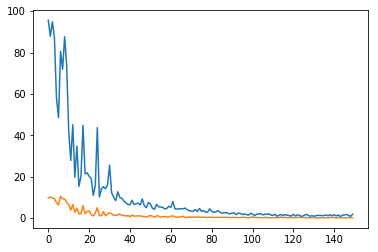

In [65]:
num_neurons = 10
learning_rates = [0.05, 0.05]
#w = np.ones((num_neurons, num_neurons))#np.random.normal(0, 1, (num_neurons, num_neurons))
w = np.random.normal(0, 1, (num_neurons, num_neurons))
w = np.tril(w) + np.tril(w, -1).T
np.fill_diagonal(w, 0)
#theta = np.zeros((num_neurons,))#np.random.normal(0, 100, (num_neurons,))
theta = np.random.normal(0, 1, (num_neurons,))

# X_c = np.matrix([
#     [1, 1, 1],
#     [-1, 1, -1],
# ])
X_c = np.random.binomial(1, 0.5, (50, num_neurons)) * 2 - 1
s1_c, s2_c = calculate_clamped_statistics(X_c)

q = []
for _ in range(150):
    X = generate_samples(w, theta, 200, 100)
    Z = calculate_normalizing_constant(X, w, theta)
    p = calculate_probabilities(X, w, theta, Z)

    p_repeat = np.tile(p, (num_neurons, 1)).T
    Q = np.multiply(p_repeat, X)
    s2 = np.dot(X.T, Q)
    s1 = np.dot(p, X)

    dLdw = s2_c - s2
    dLdtheta = s1_c - s1
    np.fill_diagonal(dLdw, 0)

    delta_w = learning_rates[0] * dLdw
    delta_theta = learning_rates[1] * np.squeeze(np.asarray(dLdtheta))

    w += delta_w
    theta += delta_theta

    if _ % 10 == 0:
        print([np.sum(np.square(dLdw)), np.sum(np.square(dLdtheta))])
    q.append([np.sum(np.square(dLdw)), np.sum(np.square(dLdtheta))])
    
plt.plot(q)

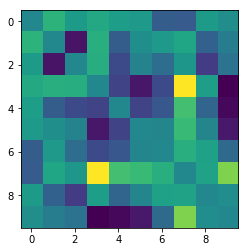

In [66]:
plt.imshow(w)

In [67]:
w, theta

(array([[ 0.        ,  0.116137  ,  0.05168454,  0.08935445,  0.05849221,
          0.04890195, -0.10937256, -0.11544779,  0.05098651,  0.0183147 ],
        [ 0.116137  ,  0.        , -0.26687498,  0.10677609, -0.10909381,
          0.02067634,  0.04769051,  0.08117596, -0.10003312, -0.02938746],
        [ 0.05168454, -0.26687498,  0.        ,  0.10187122, -0.15561147,
         -0.01207498, -0.06975292,  0.03957541, -0.18891532, -0.05515693],
        [ 0.08935445,  0.10677609,  0.10187122,  0.        , -0.1690577 ,
         -0.25782693, -0.15592205,  0.34399119,  0.06205609, -0.30006377],
        [ 0.05849221, -0.10909381, -0.15561147, -0.1690577 ,  0.        ,
         -0.16813245, -0.12596191,  0.15070231, -0.09114604, -0.28592985],
        [ 0.04890195,  0.02067634, -0.01207498, -0.25782693, -0.16813245,
          0.        , -0.00524396,  0.13739252, -0.00638294, -0.25723134],
        [-0.10937256,  0.04769051, -0.06975292, -0.15592205, -0.12596191,
         -0.00524396,  0.       

In [68]:
import operator

print(X_c)
S = generate_samples(w, theta, 10, 10000, False)
counts = {}

for r in range(S.shape[0]):
    pattern = str(S[r, :].tolist())
    pattern = pattern.replace('1.0', '+').replace('-+', '-')
    if not pattern in counts:
        counts[pattern] = 0
    counts[pattern] += 1
    
for pattern, count in sorted(counts.items(), key=operator.itemgetter(1), reverse=True):
    print("%s:\t%d" % (pattern, count))

[[ 1  1 -1  1 -1  1  1  1  1 -1]
 [-1  1 -1  1  1 -1  1  1 -1  1]
 [ 1  1 -1 -1  1  1 -1  1  1 -1]
 [ 1  1  1  1  1  1 -1  1 -1 -1]
 [ 1 -1  1 -1  1 -1  1 -1 -1  1]
 [-1  1  1 -1 -1 -1  1  1  1  1]
 [-1  1  1  1 -1 -1 -1 -1 -1  1]
 [-1  1  1  1 -1  1  1  1  1 -1]
 [-1 -1  1  1  1  1 -1  1  1  1]
 [-1 -1 -1 -1  1  1  1 -1  1  1]
 [-1  1 -1 -1  1 -1  1  1  1  1]
 [-1  1 -1  1  1 -1  1  1 -1 -1]
 [-1 -1  1 -1  1 -1 -1 -1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1  1  1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1  1]
 [ 1 -1  1 -1  1 -1 -1 -1 -1 -1]
 [ 1  1 -1 -1  1  1  1 -1  1  1]
 [ 1 -1  1 -1  1  1 -1 -1 -1  1]
 [ 1  1 -1  1 -1 -1 -1  1  1  1]
 [ 1 -1  1  1 -1 -1 -1  1 -1  1]
 [ 1  1 -1  1 -1 -1  1  1  1  1]
 [-1  1 -1 -1 -1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [ 1  1  1 -1  1  1 -1 -1 -1 -1]
 [-1  1  1  1 -1 -1 -1 -1 -1  1]
 [ 1  1  1  1  1 -1 -1 -1  1 -1]
 [ 1  1  1  1 -1  1  1  1  1 -1]
 [-1 -1  1 -1 -1  1 -1 -1  1 -1]
 [ 1 -1  1  1 -1 -1 -1 -1  1  1]
 [ 1  1 -1  1 -1 -1  1 -1  1 -1]
 [ 1 -1  1